In [1]:
import json
import torch
import numpy as np
import os
from q_storm.qStorm import QStorm
from varpi.tain_varpi import VarPi
from varpi.QLSTM import LSTM_Model
from utils.data_utils import get_test_dataset

with open("config.json") as f:
    config = json.load(f)


/home/chaddicus/miniconda3/envs/opt-price/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_datas = {}
for i in range(15, 31):
    test_datas[i] = get_test_dataset(219, "2020-01-01", "2025-01-01", i, True)

In [3]:
q_storm = torch.load('models/q_storm.pth')
varphi = torch.load('models/varphi.pth')
varpi = torch.load('models/varpi.pth')

/tmp/ipykernel_28780/1969374420.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_storm = torch.load('models/q_storm.pth')
/tmp/ipykernel_28780/1969374420.py:2: FutureWa

In [4]:
q_storm

QStorm(
  (activation): ReLU()
  (input_net): Sequential(
    (0): Linear(in_features=40, out_features=1054, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1054, out_features=1054, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1054, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=32, bias=True)
  )
  (dgm_net): ModuleList(
    (0-3): 4 x OptimizedDGMLayer(
      (z_matrix): Linear(in_features=96, out_features=32, bias=True)
      (g_matrix): Linear(in_features=96, out_features=32, bias=True)
      (r_matrix): Linear(in_features=96, out_features=32, bias=True)
      (h_matrix): Linear(in_features=96, out_features=32, bias=True)
    )
  )
  (output_net): Linear(in_features=32, out_features=1, bias=True)
)

In [5]:
varphi

LSTM_Model(
  (normalize_lstm): LSTM(49, 16, batch_first=True, dropout=0.17780297705940562)
  (normalize_module): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.17780297705940562, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.17780297705940562, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.17780297705940562, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ELU(alpha=1.0)
    (11): Dropout(p=0.17780297705940562, inplace=False)
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): ELU(alpha=1.0)
    (14): Dropout(p=0.17780297705940562, inplace=False)
    (15): Linear(in_features=32, out_features=37, bias=True)
  )
  (market_lstm): LSTM(21, 16, batch_first=True, dropout=0.17780297705940562)
  (market_module): Sequential(

In [6]:
varpi

VarPi(
  (input_layer): Linear(in_features=39, out_features=4096, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=4096, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=2048, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=2048, bias=True)
    (7): ReLU()
    (8): Linear(in_features=2048, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): Linear(in_features=256, out_features=64, bias=True)
    (15): ReLU()
    (16): Linear(in_features=64, out_features=32, bias=True)
    (17): ReLU()
  )
  (output_layer): Linear(in_features=32, out_features=37, bias=True)
)

In [7]:
import pandas as pd
opt_df = pd.read_parquet('options_data/OptionMetrics.parquet', engine='pyarrow')  # or engine='fastparquet'
opt_df["date"] = pd.to_datetime(opt_df["date"])
opt_df["exdate"] = pd.to_datetime(opt_df["exdate"])
opt_df["ticker"] = opt_df["symbol"].str.split(" ").str[0]
opt_df["days_to_expiration"] = (opt_df["exdate"] - opt_df["date"]).dt.days

In [8]:
tickers = config["tickers"]["options"]
opt_df = opt_df[(opt_df["ticker"].isin(tickers)) & (opt_df["exercise_style"] == "A")]

In [9]:
date  = opt_df["date"].unique()
day = np.random.choice(date)
day

np.datetime64('2023-04-19T00:00:00.000000000')

In [10]:
call_options = opt_df[(opt_df["date"] == day) & (opt_df["cp_flag"] == "C")]

In [11]:
market_data = pd.read_csv("data/market_data/market_data.csv", index_col=0, parse_dates=True)
rf_df = market_data["^IRX"]

In [12]:
rf = rf_df.loc[day].item()/100/365

In [13]:
files = os.listdir("options_data")
ticker_data = pd.DataFrame()
for file in files:
    if file.endswith(".csv"):
        ticker = file.split(".csv")[0]
        sub_df = pd.read_csv(f"options_data/{file}", index_col=0, parse_dates=True)
        sub_df.rename(columns={"Close": f"{ticker}"}, inplace=True)
        ticker_data = ticker_data.join(sub_df, how='right')

In [14]:
ticker_data = ticker_data.loc["2020-01-01":]

In [15]:
ticker_data_rolling_mean = ticker_data.rolling(window=100).mean()
ticker_data_rolling_std = ticker_data.rolling(window=100).std()
ticker_data_normalized = (ticker_data - ticker_data_rolling_mean) / ticker_data_rolling_std
ticker_volatility = ticker_data.pct_change().rolling(window=100).std()

In [16]:
call_options

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,days_to_expiration
2333652,101121,2023-04-19,AMD 230421C100000,1,2023-04-21,2023-04-19,C,100000,0.01,0.02,...,0,5,None,0,None,ADVANCED MICRO DEVICES INC.,None,A,None,2
2333653,101121,2023-04-19,AMD 230421C101000,1,2023-04-21,2023-04-19,C,101000,0.01,0.02,...,0,5,None,0,None,ADVANCED MICRO DEVICES INC.,None,A,None,2
2333654,101121,2023-04-19,AMD 230421C102000,1,2023-04-21,2023-04-19,C,102000,0.01,0.02,...,0,5,None,0,None,ADVANCED MICRO DEVICES INC.,None,A,None,2
2333655,101121,2023-04-19,AMD 230421C103000,1,2023-04-21,2023-04-19,C,103000,0.00,0.01,...,0,5,None,0,None,ADVANCED MICRO DEVICES INC.,None,A,None,2
2333656,101121,2023-04-19,AMD 230421C104000,1,2023-04-21,2023-04-19,C,104000,0.00,0.01,...,0,5,None,0,None,ADVANCED MICRO DEVICES INC.,None,A,None,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505130,213572,2023-04-19,ZM 230512C91000,1,2023-05-12,2023-04-19,C,91000,0.00,0.03,...,0,4,None,0,None,ZOOM VIDEO COMMUNICATIONS IN,None,A,None,23
6505131,213572,2023-04-19,ZM 230512C92000,1,2023-05-12,2023-04-18,C,92000,0.00,0.03,...,0,4,None,0,None,ZOOM VIDEO COMMUNICATIONS IN,None,A,None,23
6505132,213572,2023-04-19,ZM 230512C93000,1,2023-05-12,2023-04-04,C,93000,0.00,0.09,...,0,4,None,0,None,ZOOM VIDEO COMMUNICATIONS IN,None,A,None,23
6505133,213572,2023-04-19,ZM 230512C94000,1,2023-05-12,None,C,94000,0.00,0.03,...,0,4,None,0,None,ZOOM VIDEO COMMUNICATIONS IN,None,A,None,23


In [17]:
def get_combined_daily_data(options_df, sprime_series, smu_series, ssigma_series, date, rf_rate=None):
    """
    Combine options data with normalized stock prices for a specific date

    Parameters:
    -----------
    options_df: pandas DataFrame
        Options data containing all options fields
    sprime_series: pandas Series
        Normalized stock prices (S_prime) indexed by ticker
    date: str or datetime
        The specific date to process
    rf_rate: float, optional
        Risk-free rate for the given date

    Returns:
    --------
    DataFrame containing combined data with:
        S_prime: normalized stock price from sprime_series
        K_prime: normalized strike prices
        T_prime: normalized time
        rf: risk-free rate
    """
    # Filter options data for the specific date
    daily_options = options_df[options_df['date'] == date].copy()

    if len(daily_options) == 0:
        raise ValueError(f"No options data found for date {date}")

    # Get S_prime for each ticker
    daily_options['S_z'] = daily_options['ticker'].map(sprime_series)
    daily_options["S_mu"] = daily_options["ticker"].map(smu_series)
    daily_options["S_sigma"] = daily_options["ticker"].map(ssigma_series)
    daily_options["S"] = daily_options["ticker"].map(ticker_data.loc[date])
    daily_options["volatility"] = daily_options["ticker"].map(ticker_volatility.loc[date])

    # Calculate normalized strike price using S_prime
    # Note: We might need to adjust this normalization depending on your needs
    daily_options["K"] = daily_options["strike_price"] 
    

    # Add a column to indicate if the strike price needs to be divided by 100
    def check_strike_scaling(row):
        # Threshold logic: If the strike price is abnormally large, assume it's in cents
        if row['strike_price'] > 1000:  # Adjust this threshold if necessary
            return True  # Needs to be divided by 100
        return False  # Does not need adjustment

    # Apply the logic to each row
    daily_options['needs_division'] = daily_options.apply(check_strike_scaling, axis=1)

    # Add a corrected strike price column
    daily_options['K'] = daily_options.apply(
        lambda row: row['K'] / 100 if row['needs_division'] else row['K'], axis=1
    )

    daily_options["S_prime"] = daily_options["S"]/daily_options["K"]
    # Normalize time (you mentioned this is usually just one)
    daily_options['t_prime'] = daily_options['days_to_expiration']
    
    daily_options["price"] = (daily_options["best_bid"] + daily_options["best_offer"])/2
    daily_options["price_prime"] = daily_options["price"] / daily_options["K"]
    daily_options["index"] = daily_options.index

    # Add risk-free rate if provided
    if rf_rate is not None:
        daily_options['rf'] = rf_rate

    # Keep only relevant columns
    relevant_cols = ['index', 'ticker', 'S_prime', 'K', 't_prime', 'S', 'volume','days_to_expiration', 'price_prime', 'price', 'volatility']
    if rf_rate is not None:
        relevant_cols.append('rf')

    return daily_options[relevant_cols]

In [18]:
date = pd.to_datetime(day).strftime("%Y-%m-%d")
s_series = ticker_data_normalized.loc[date]
s_mu_series = ticker_data_rolling_mean.loc[date]
s_sigma_series = ticker_data_rolling_std.loc[date]
refined_df = get_combined_daily_data(call_options, s_series, s_mu_series, s_sigma_series, date)
refined_df

,index,ticker,S_prime,K,t_prime,S,volume,days_to_expiration,price_prime,price,volatility
2333652,2333652,AMD,0.089940,1000.0,2,89.940002,4164,2,0.000015,0.015,0.030209
2333653,2333653,AMD,0.089050,1010.0,2,89.940002,1528,2,0.000015,0.015,0.030209
2333654,2333654,AMD,0.088176,1020.0,2,89.940002,282,2,0.000015,0.015,0.030209
2333655,2333655,AMD,0.087320,1030.0,2,89.940002,192,2,0.000005,0.005,0.030209
2333656,2333656,AMD,0.086481,1040.0,2,89.940002,14,2,0.000005,0.005,0.030209
...,...,...,...,...,...,...,...,...,...,...,...
6505130,6505130,ZM,0.074451,910.0,23,67.750000,60,23,0.000016,0.015,0.028824
6505131,6505131,ZM,0.073641,920.0,23,67.750000,0,23,0.000016,0.015,0.028824
6505132,6505132,ZM,0.072849,930.0,23,67.750000,0,23,0.000048,0.045,0.028824
6505133,6505133,ZM,0.072074,940.0,23,67.750000,0,23,0.000016,0.015,0.028824


In [19]:
unique_combs = refined_df[["days_to_expiration", "ticker"]].drop_duplicates()

In [20]:
unique_combs["idx"] = 0
unique_tickers = unique_combs["ticker"].unique()
varphi_inputs = []
for ticker in unique_tickers:
    sub_days = unique_combs[unique_combs["ticker"] == ticker]["days_to_expiration"].values
    for day_till in sub_days:
        if day_till <= 15:
            day_till = 15
        test_datas[day_till].set_main_asset(ticker)
        sub_varphi_inps = test_datas[day_till].query_by_date(day)
        varphi_inputs.append(sub_varphi_inps)
        unique_combs.loc[(unique_combs["ticker"] == ticker) & (unique_combs["days_to_expiration"] == day_till), "idx"] = len(varphi_inputs) - 1

/home/chaddicus/opt-price/utils/data_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s = torch.tensor(self.s[idx], dtype=torch.float32).to(
/home/chaddicus/opt-price/utils/data_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s = torch.tensor(self.s[idx], dtype=torch.float32).to(
/home/chaddicus/opt-price/utils/data_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s = torch.tensor(self.s[idx], dtype

In [21]:
unique_combs

,days_to_expiration,ticker,idx
2333652,2,AMD,0
2333812,9,AMD,0
2333938,16,AMD,2
2334080,23,AMD,3
2605870,2,BAC,0
...,...,...,...
6447786,23,AMC,63
6504818,2,ZM,0
6504916,9,ZM,0
6505004,16,ZM,66


In [22]:
varphi_outputs = []
for varphi_input in varphi_inputs:
    X, _ , Z, _, _  = varphi_input
    X = X.unsqueeze(0)
    Z = Z.unsqueeze(0)
    varphi_q, _  = varphi(X, _, Z)
    varphi_q = varphi_q/100
    varphi_q = varphi_q.squeeze()
    varphi_outputs.append(varphi_q)
varphi_outputs = torch.stack(varphi_outputs)

In [23]:
t = unique_combs["days_to_expiration"] / np.where(unique_combs["days_to_expiration"].values < 15, 15, unique_combs["days_to_expiration"].values)
T = unique_combs["days_to_expiration"].values/30
t = torch.tensor(t.values).float().unsqueeze(1)
T = torch.tensor(T).float().unsqueeze(1)

device = varphi_q.device
t = t.to(device)
T = T.to(device)

varpi_outputs = varpi(varphi_outputs, t, T)

In [24]:
def match_quantiles_with_options(options_df, quantiles_df):
    """
    Match options data with their corresponding quantile indexes
    
    Parameters:
    -----------
    options_df: pandas DataFrame
        Options data containing days_to_expiration and ticker
    quantiles_df: pandas DataFrame
        DataFrame with days_to_expiration, ticker, and idx columns
    
    Returns:
    --------
    DataFrame with matched options and quantile indexes
    """
    # First, handle days < 15 by setting them to 15
    options_df = options_df.copy()
    options_df['days_to_expiration_adj'] = options_df['days_to_expiration']#.clip(lower=15)
    
    # Create matching key in both dataframes
    options_df['match_key'] = options_df['days_to_expiration_adj'].astype(str) + options_df['ticker']
    quantiles_df['match_key'] = quantiles_df['days_to_expiration'].astype(str) + quantiles_df['ticker']
    
    # Merge the dataframes
    merged_df = options_df.merge(
        quantiles_df[['match_key', 'idx']],
        on='match_key',
        how='left'
    )
    
    # Clean up
    merged_df.drop(['match_key', 'days_to_expiration_adj'], axis=1, inplace=True)
    
    return merged_df

In [25]:
q_storm_inps = match_quantiles_with_options(refined_df, unique_combs)
q_storm_inps

,index,ticker,S_prime,K,t_prime,S,volume,days_to_expiration,price_prime,price,volatility,idx
0,2333652,AMD,0.089940,1000.0,2,89.940002,4164,2,0.000015,0.015,0.030209,0
1,2333653,AMD,0.089050,1010.0,2,89.940002,1528,2,0.000015,0.015,0.030209,0
2,2333654,AMD,0.088176,1020.0,2,89.940002,282,2,0.000015,0.015,0.030209,0
3,2333655,AMD,0.087320,1030.0,2,89.940002,192,2,0.000005,0.005,0.030209,0
4,2333656,AMD,0.086481,1040.0,2,89.940002,14,2,0.000005,0.005,0.030209,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3057,6505130,ZM,0.074451,910.0,23,67.750000,60,23,0.000016,0.015,0.028824,67
3058,6505131,ZM,0.073641,920.0,23,67.750000,0,23,0.000016,0.015,0.028824,67
3059,6505132,ZM,0.072849,930.0,23,67.750000,0,23,0.000048,0.045,0.028824,67
3060,6505133,ZM,0.072074,940.0,23,67.750000,0,23,0.000016,0.015,0.028824,67


In [26]:
import numpy as np
from scipy.stats import norm

def black_scholes_american_call(S, K, T, r, sigma, q=0):
    """
    Approximate price of an American call option using Black-Scholes (for non-dividend stocks) 
    or the Barone-Adesi-Whaley approximation (for dividends).
    
    Args:
        S (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity (years)
        r (float): Risk-free rate (annualized)
        sigma (float): Volatility (annualized)
        q (float): Dividend yield (annualized, default=0)
    
    Returns:
        float: Option price
    """
    if q == 0:
        # No dividends: American call = European call
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        # Dividends: Barone-Adesi-Whaley approximation
        # Critical price S* (needs iterative solving)
        from scipy.optimize import fsolve
        def equation(S_star):
            d1 = (np.log(S_star / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
            return S_star - K - black_scholes_american_call(S_star, K, T, r, sigma, q=0)
        
        S_star_initial_guess = K * (1 + 1 / (np.sqrt(2 * np.pi) * sigma * np.sqrt(T)))
        S_star = fsolve(equation, S_star_initial_guess)[0]
        
        if S >= S_star:
            # Early exercise is optimal
            call_price = S - K
        else:
            # Price as European call + early exercise premium
            d1 = (np.log(S / S_star) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            A = (S_star / (1 - np.exp(-q * T) * norm.cdf(d1))) * (1 - np.exp(-q * T))
            call_price = black_scholes_american_call(S, K, T, r, sigma, q=0) + A * (S / S_star)**(0.5 * (1 + np.sqrt(1 + 8*r/(sigma**2))))
    
    return call_price

In [27]:
Vs = []
V_primes = []
BS_Vs = []
device = "cuda"
rf_torch = torch.tensor([[rf]]).float().to(device)
for idx, row in q_storm_inps.iterrows():
    S_prime = row["S_prime"]
    t_prime = row["t_prime"]
    idx = row["idx"]
    varpi_q = varpi_outputs[idx].unsqueeze(0)
    S_prime = torch.tensor([[S_prime]]).float().to(device)
    t_prime = torch.tensor([[t_prime]]).float().to(device)
    V_prime = q_storm(S_prime, t_prime, rf_torch, varpi_q)
    K = row["K"]
    BS_V = black_scholes_american_call(row["S"], K, row["days_to_expiration"]/365, rf*365, row["volatility"]*np.sqrt(365), 0)
    V = V_prime * K
    Vs.append(V.item())
    V_primes.append(V_prime.item())
    BS_Vs.append(BS_V)
q_storm_inps["V"] = Vs
q_storm_inps["V_prime"] = V_primes
q_storm_inps["BS_V"] = BS_Vs
print(f"V: {V.item()}, V_prime: {V_prime.item()}")

V: 1.5261731147766113, V_prime: 0.0016064980300143361


In [28]:
row["S"], K, row["days_to_expiration"]/365, rf*365, row["volatility"]*np.sqrt(365),

(67.75,
 950.0,
 0.06301369863013699,
 0.04994999885559082,
 np.float64(0.5506813035243746))

In [29]:
# clip the all values that are less than 1e-3 of BS_V to 0
q_storm_inps.loc[q_storm_inps["BS_V"] < 1e-3, "BS_V"] = 0

In [30]:
q_storm_inps[["V", "V_prime", "price", "price_prime", "BS_V"]].describe()

,V,V_prime,price,price_prime,BS_V
count,3062.000000,3062.000000,3062.000000,3062.000000,3062.000000
mean,0.888142,0.010352,12.083075,0.017076,0.219112
std,2.490745,0.120068,21.740795,0.035967,2.263153
min,0.003368,0.000082,0.005000,0.000001,0.000000
25%,0.115902,0.000117,0.041250,0.000048,0.000000
50%,0.318280,0.000280,2.125000,0.003232,0.000000
75%,0.867482,0.000983,14.156250,0.019090,0.000000
max,37.785725,2.519048,150.900000,0.748000,36.047997


In [31]:
q_storm_inps[["S_prime", "S", "days_to_expiration", "price", "price_prime", "V_prime", "V", "BS_V"]].corr()

,S_prime,S,days_to_expiration,price,price_prime,V_prime,V,BS_V
S_prime,1.000000,-0.089946,0.013004,0.040773,0.393564,0.892351,0.865832,0.927980
S,-0.089946,1.000000,-0.004065,0.428877,-0.045131,-0.060141,0.106241,-0.071504
days_to_expiration,0.013004,-0.004065,1.000000,0.007104,-0.019522,0.019068,0.241626,0.020634
price,0.040773,0.428877,0.007104,1.000000,0.496037,-0.034644,0.007211,-0.043489
price_prime,0.393564,-0.045131,-0.019522,0.496037,1.000000,0.284154,0.217875,0.259488
V_prime,0.892351,-0.060141,0.019068,-0.034644,0.284154,1.000000,0.899823,0.960282
V,0.865832,0.106241,0.241626,0.007211,0.217875,0.899823,1.000000,0.938772
BS_V,0.927980,-0.071504,0.020634,-0.043489,0.259488,0.960282,0.938772,1.000000


In [55]:
q_storm_inps.sample(5)

,index,ticker,S_prime,K,t_prime,S,volume,days_to_expiration,price_prime,price,volatility,idx,V,V_prime,BS_V,diff
3035,6505108,ZM,0.098188,690.0,23,67.750000,7,23,0.003239,2.235,0.028824,67,1.210335,0.001754,0.000000,-1.024665
2175,4359146,COP,0.058714,1700.0,2,99.813202,0,2,0.000047,0.080,0.022630,0,0.160215,0.000094,0.000000,0.080215
2804,6447654,AMC,1.133333,45.0,2,51.000000,9294,2,0.013111,0.590,0.075287,0,8.597261,0.191050,6.311229,8.007261
2259,4359343,COP,0.095060,1050.0,16,99.813202,5,16,0.002871,3.015,0.022630,46,0.786653,0.000749,0.000000,-2.228347
2764,5707193,GME,0.106550,200.0,23,21.309999,0,23,0.008700,1.740,0.058106,59,0.348991,0.001745,0.000000,-1.391009


In [33]:
q_storm_inps["diff"] = (q_storm_inps["V"]  - q_storm_inps["price"])

In [49]:
q_storm_inps.loc[~q_storm_inps["ticker"].isin(["AMC", "HD", "MCD", "CVX"])].sort_values("diff", ascending=False).head(5)

,index,ticker,S_prime,K,t_prime,S,volume,days_to_expiration,price_prime,price,volatility,idx,V,V_prime,BS_V,diff
1917,4072079,NKE,0.076451,1600.0,23,122.321800,0,23,0.000006,0.010,0.019491,35,2.214148,0.001384,0.0,2.204148
653,2667286,JPM,0.081990,1650.0,23,135.283569,0,23,0.000009,0.015,0.016558,11,2.214027,0.001342,0.0,2.199027
1916,4072078,NKE,0.078917,1550.0,23,122.321800,0,23,0.000006,0.010,0.019491,35,2.161129,0.001394,0.0,2.151129
652,2667285,JPM,0.084552,1600.0,23,135.283569,12,23,0.000016,0.025,0.016558,11,2.163183,0.001352,0.0,2.138183
651,2667284,JPM,0.085894,1575.0,23,135.283569,0,23,0.000029,0.045,0.016558,11,2.138027,0.001357,0.0,2.093027


In [51]:
q_storm_inps.loc[~q_storm_inps["ticker"].isin(["AMC", "HD", "MCD", "CVX"])].sort_values("diff", ascending=False).tail(5)

,index,ticker,S_prime,K,t_prime,S,volume,days_to_expiration,price_prime,price,volatility,idx,V,V_prime,BS_V,diff
873,2954696,XOM,0.258452,425.0,2,109.841965,0,2,0.174176,74.025,0.017715,0,0.090895,0.000214,0.0,-73.934105
1765,4071762,NKE,0.244644,500.0,2,122.321800,0,2,0.151400,75.700,0.019491,0,0.099093,0.000198,0.0,-75.600907
496,2666955,JPM,0.208129,650.0,2,135.283569,0,2,0.117231,76.200,0.016558,0,0.106606,0.000164,0.0,-76.093394
1764,4071761,NKE,0.257520,475.0,2,122.321800,0,2,0.164526,78.150,0.019491,0,0.101061,0.000213,0.0,-78.048939
1763,4071760,NKE,0.271826,450.0,2,122.321800,0,2,0.179278,80.675,0.019491,0,0.103858,0.000231,0.0,-80.571142


In [36]:
q_storm_inps.loc[q_storm_inps["ticker"] == "GME"].sort_values("V", ascending=False).head(5)

,index,ticker,S_prime,K,t_prime,S,volume,days_to_expiration,price_prime,price,volatility,idx,V,V_prime,BS_V,diff
2683,5707014,GME,0.852400,25.0,9,21.309999,0,9,0.748000,18.700,0.058106,0,1.001751,0.040070,0.39623,-17.698249
2787,5707216,GME,0.062676,340.0,23,21.309999,8,23,0.000265,0.090,0.058106,59,0.514718,0.001514,0.00000,0.424718
2786,5707215,GME,0.064576,330.0,23,21.309999,0,23,0.000303,0.100,0.058106,59,0.502571,0.001523,0.00000,0.402571
2785,5707214,GME,0.066594,320.0,23,21.309999,100,23,0.000359,0.115,0.058106,59,0.490448,0.001533,0.00000,0.375448
2784,5707213,GME,0.068742,310.0,23,21.309999,17,23,0.000403,0.125,0.058106,59,0.478355,0.001543,0.00000,0.353355


In [37]:
q_storm_inps.loc[q_storm_inps["ticker"] == "GME"].sort_values("V", ascending=False).tail(5)

,index,ticker,S_prime,K,t_prime,S,volume,days_to_expiration,price_prime,price,volatility,idx,V,V_prime,BS_V,diff
2568,5706808,GME,0.185304,115.0,2,21.309999,0,2,0.084565,9.725,0.058106,0,0.016924,0.000147,0.0,-9.708076
2567,5706807,GME,0.189422,112.5,2,21.309999,0,2,0.088667,9.975,0.058106,0,0.016870,0.000150,0.0,-9.958130
2566,5706806,GME,0.193727,110.0,2,21.309999,0,2,0.092955,10.225,0.058106,0,0.016831,0.000153,0.0,-10.208169
2564,5706804,GME,0.213100,100.0,2,21.309999,0,2,0.112500,11.250,0.058106,0,0.016810,0.000168,0.0,-11.233190
2565,5706805,GME,0.202952,105.0,2,21.309999,0,2,0.102381,10.750,0.058106,0,0.016791,0.000160,0.0,-10.733209


<Axes: ylabel='Frequency'>

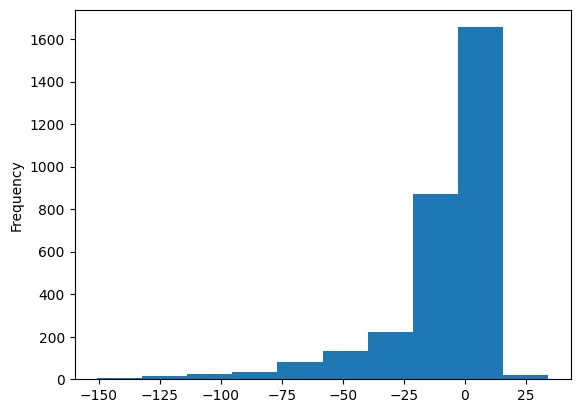

In [52]:
q_storm_inps["diff"].plot(kind='hist')

In [53]:
call_options[['ticker', 'strike_price', 'best_bid', 'best_offer', 'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'theta', 'vega', 'days_to_expiration', 'forward_price']].sample(5)

,ticker,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,theta,vega,days_to_expiration,forward_price
4071740,NKE,134000,0.00,0.01,1,502,0.334709,0.005099,0.004732,-4.214589,0.137091,2,None
3426524,MCD,257500,33.35,33.90,0,14,NaN,NaN,NaN,NaN,NaN,2,None
4071762,NKE,50000,75.40,76.00,0,12,4.406944,0.998606,0.000112,-19.334390,0.042526,2,None
2333813,AMD,101000,0.12,0.13,162,1446,0.435476,0.049891,0.016749,-13.041190,1.455714,9,None
5706870,GME,41250,0.00,0.01,0,368,3.169094,0.003488,0.002099,-4.788875,0.016529,2,None


In [40]:
call_options.loc[6447655]

secid                                       189943
date                           2023-04-19 00:00:00
symbol                              AMC 230421C500
symbol_flag                                      1
exdate                         2023-04-21 00:00:00
last_date                               2023-04-19
cp_flag                                          C
strike_price                                   500
best_bid                                       4.5
best_offer                                    4.65
volume                                           5
open_interest                                    6
impl_volatility                                NaN
delta                                          NaN
gamma                                          NaN
vega                                           NaN
theta                                          NaN
optionid                                 153373569
cfadj                                            1
am_settlement                  

In [41]:
call_options.loc[5707194]

secid                               113993
date                   2023-04-19 00:00:00
symbol                    GME 230512C20500
symbol_flag                              1
exdate                 2023-05-12 00:00:00
last_date                       2023-04-18
cp_flag                                  C
strike_price                         20500
best_bid                              1.32
best_offer                            1.63
volume                                   0
open_interest                           25
impl_volatility                   0.527677
delta                             0.624892
gamma                             0.138652
vega                              1.999516
theta                            -7.182487
optionid                         153573090
cfadj                                    1
am_settlement                            0
contract_size                          100
ss_flag                                  0
forward_price                         None
expiry_indi

In [42]:
call_options["strike_price"].min()

np.int64(500)